# Homework 1
Class: PHYS 650 - Ruben Delgado

Author: Maurice Roots

---
#### 1. The spaceborne lidar CALIOP has a vertical resolution of 30-60 meters. What is the laser pulse length? 

#### Vertical resolution for time-of-flight lidar system is given by: $\Delta R = \frac{c \cdot \tau}{2}$, where $\delta R$ is the vertical resolution, $c$ is the speed of light in a vacuum, $\tau$ os the laser pulse duration, the division by 2 is for the round trip. 

#### Answer: 
Therefore for vertical resolution ($\Delta R$) of 30 - 60 meters such as CALIOP the laser pulse length ($\tau$) must be **0.2 - 0.4 $\mu m$**

#### Math:
### $\Delta R = \frac{c \cdot \tau}{2}$ $\longrightarrow$ $\tau = \frac{(\Delta R \cdot 2)}{c}$ $\longrightarrow$ $\tau = \frac{(30  m \cdot 2)}{3 \times 10^8  m/s}$

---
#### 2. You accidentally mixed up the narrowband passband filters for your lidar system while packing up your instrument for a field deployment. How would you know which filter is the correct one for the elastic channel?

#### Answer: 
For an elastic lidar system the return signal is the same as the output signal. One way to tell the difference is to use the bandpass filters on the output signal and check if anything come through. If signal is transmitted than that filter is for the elastic channel.  

---
#### 3. For the UMBC CHM15k determine its System Constant (K). 
    A. Generate plots as in Figure 3 from Li et al.
        a. Copy of article in Blackboard and here: https://www.mdpi.com/2072-4292/13/18/3626/htm
        b. UMBC CHM15K datafile can be found here: 20200308_Catonsville-MD_CHM160112_000.nc
            Variable to plot: x: time; y: range; z: beta_raw
            Use the IAD_20200308_12Z.txt in Lidar/Data folder in Blackboard to calculate molecular 
            backscatter coefficients and the two-way molecular transmittance to determine the System 
            Constant (K). 
    B. Indicate and justify your selection of range heights and times selected for determination.
        Copy of your script/code needs to be submitted with homework.

In [1]:
# Utilities
from pathlib import Path
from datetime import datetime
from scipy import stats

# Data Processing
import numpy as np
import xarray as xr
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.units as munits
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle

In [2]:
# Function Space
def importing_ceilometer(FilePaths, variables=None, LT=None, **kwargs):
    data = {} # all data will be stored into a nested dictionary
    files = {}
    FilePaths = [Path(filePath) for filePath in FilePaths] # converting to Pathlib objects

    for filePath in FilePaths:
        if filePath.is_file() is False:
            print('PATH IS NOT FOUND ON MACHINE')
            return

        fileName = filePath.name
        data[fileName] = {} # Nested Dictionary
        with xr.open_dataset(filePath) as file: # importing data as a xarrays instance
            data[fileName]["datetime"] = file.time.values
            data[fileName]["dateNum"] = np.array([mdates.date2num(t) for t in data[fileName]["datetime"]])
            if LT: data[fileName]["dateNum"] = data[fileName]["dateNum"] + (LT/24)
            data[fileName]["range"] = file.range.values
            data[fileName]["beta_raw"] = file.beta_raw.values
            data[fileName]["beta_raw"][data[fileName]["beta_raw"] == 0] = np.nan
            data[fileName]["beta_raw"] = data[fileName]["beta_raw"].T
            data[fileName]["instrument_pbl"] = file.pbl.values
            data[fileName]["lat_lon_alt"] = [file.longitude.values, file.latitude.values, file.altitude.values]

            if "vars" in kwargs.keys():
                for var in kwargs["vars"]:
                    data[fileName][var] = file[var].values

            data[fileName]["datasets"] = list(file.keys())
            files[fileName] = file

    return data, files

def plot(data,
         clims=[10**4, 10**6],
         cticks=np.arange(10**4, 10**6, (10**6 - 10**4) / 5),
         xlabel="Datetime (UTC)",
         **kwargs):

    fig, ax = plt.subplots(figsize=(15, 8))

    for key in data.keys():
        X, Y, Z = (data[key]["dateNum"], data[key]["range"].flatten()/1000, np.abs(data[key]["beta_raw"]))
        im = ax.pcolormesh(X, Y, Z, cmap="viridis", shading="nearest", norm=LogNorm(vmin=clims[0], vmax=clims[1]))

    cbar = fig.colorbar(im, ax=ax, pad=0.01, ticks=cticks)
    cbar.set_label(label=r"Aerosol Backscatter ($Log_{10}$)", size=16, weight="bold")

    if "title" in kwargs.keys():
        plt.title(kwargs["title"], fontsize=20)
    else: plt.title(r"Ceilometer Backscatter", fontsize=20)

    ax.set_ylabel("Altitude (km AGL)", fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)

    if "xlims" in kwargs.keys():
        lim = kwargs["xlims"]
        lims = [np.datetime64(lim[0]), np.datetime64(lim[-1])]
        ax.set_xlim(lims)

    if "ylims" in kwargs.keys():
        ax.set_ylim(kwargs["ylims"])

    if "yticks" in kwargs.keys():
        ax.set_yticks(kwargs["yticks"], fontsize=20)

    plt.setp(ax.get_yticklabels(), fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=16)
    cbar.ax.tick_params(labelsize=16)

    converter = mdates.ConciseDateConverter()
    munits.registry[datetime] = converter

    ax.xaxis_date()
    
    if "target" in kwargs.keys():
        #add rectangle to plot
        ax.add_patch(Rectangle(*kwargs["target"],
             edgecolor = 'pink',
             fill=False,
             lw=1))
        
    if "savefig" in kwargs.keys():
        plt.savefig(f"{kwargs['savefig']}", dpi=300)

    plt.show()

    return (X, Y, Z)


def beta_mol(P, T, wavelength):
    '''
    Calculates Molecular Backscatter Coeffients: B_mol(z)

    Parameters
    ----------
    P : array-like
        Pressure (Pa).
    T : array-like
        Temperature (K).
    wavelength : float
        Wavelength (m).

    Returns
    -------
    beta : array-like
        Molecular Backscatter (m^-1 sr^-1).

    '''

    beta = 2.938e-32 * (P / T) * (wavelength**(-4.0117))

    return beta

def trans_mol(betaMol, altitude, S_mol=((8*np.pi)/3)):
    '''
    Calculates 2-way molecular Transmittance: [T_mol(z)]^2

    Parameters
    ----------
    betaMol : array-like
        Molecular Backscatter Coefficients (m^-1 sr^-1).
    altitude : array-lije
        Altitude (m).
    S_mol : float, optional
        Molecular Lidar Ration: (alpha / beta). The default is ((8*np.pi)/3).

    Returns
    -------
    trans : float
        Calculates 2-way molecular Transmittance: [T_mol(z)]^2.

    '''

    trans = [S_mol*betaMol[i]*((altitude[i] - altitude[i-1])/1000) for i in np.arange(1, len(altitude))]
    trans = np.exp(-2*np.sum(trans))
    return trans

def SA76(zkm):
    '''
    Calculates Pressure and Temperature for a Standard United States Atmsphere 1976 (SA76)

    Parameters
    ----------
    zkm  : array-like, float
        An array of altitudes [0 <= zkm <= 86 km]: kilometers 

    Returns
    -------
    pressure : array-like, float
        pressure profile at supplied altitude (zkm): Pa
    temperature : array-like, float
        temperature profiel at supplied altitudes (zkm): Kelvin
    '''
    
    M = 28.9644 # Average molecular weight for air
    g0 = 9.80665 # m/s^2 acceleration due to gravity
    RE = 6378.14 # Earth's radius [km]
    T0 = 288.15 # 15C
    P0 = 101325.0 # 1 atmospere [Pa]
    R = 8.31447 # Gas Constant [J/K/mol]
    kB = 1.38065e-23 # [J/K] Boltzmann's Constant

    try:
        n = len(zkm)
    except TypeError:
        n = 1
        zkm = np.array([zkm])
    P = np.zeros_like(zkm)
    T = np.zeros_like(zkm)
    numberDensity =  np.zeros_like(zkm)
    ##% Geopotential Heights
    hTbl= np.array([0.0, 11.0, 20.0, 32.0, 47.0, 51.0, 71.0, RE*86.0/(RE+86.0)])
    # %Temperature gradient in each Layer
    dtdhTbl= np.array([-6.5, 0.0, 1.0, 2.8, 0.0, -2.8, -2.0])
    # %Temperature Table
    tempTbl = np.array([288.15, 216.65, 216.65, 228.65, 270.65, 270.65, 214.65, 186.938])
    # %Pressure Table
    pressureTbl = np.array([101325.0, 22632.7, 5475.18, 868.094, 110.92, 66.9478, 3.95715, 0.373207])


    for k in range(n):
        h = zkm[k]*RE/(zkm[k]+RE)
        # %Find the layer
        # i = int(hTbl[hTbl<= h].sum())
        i = int(np.sum(hTbl<= h))-1
        T[k] = tempTbl[i]+dtdhTbl[i]*(h-hTbl[i])
        if abs(dtdhTbl[i]) <=0.001:
            ratio = np.exp(-M*g0*(h-hTbl[i])/(R*tempTbl[i]))
        else:
            ratio = ((tempTbl[i]+dtdhTbl[i]*(h-hTbl[i]))/tempTbl[i])**(-M*g0/(R*dtdhTbl[i]))

        P[k]= ratio*pressureTbl[i];

    # numberDensity = P/(kB*T);
    return P,T


def binned_alts(data_array, altitude, bins=np.arange(0, 15000, 100)):
        data = pd.DataFrame({"data":data_array, "altitude":altitude})
        data["Alt_Bins"] = pd.cut(altitude, bins=bins)
        new = data.groupby("Alt_Bins").mean().reset_index()
        new.dropna(inplace=True)
        return new

In [3]:
figPath = r""
dataPath = [r"20200308_Catonsville-MD_CHM160112_000.nc"]

# Unpacking the Ceilometer Data from the NetCDF file
Catonsville_ceilometer, files = importing_ceilometer(dataPath)

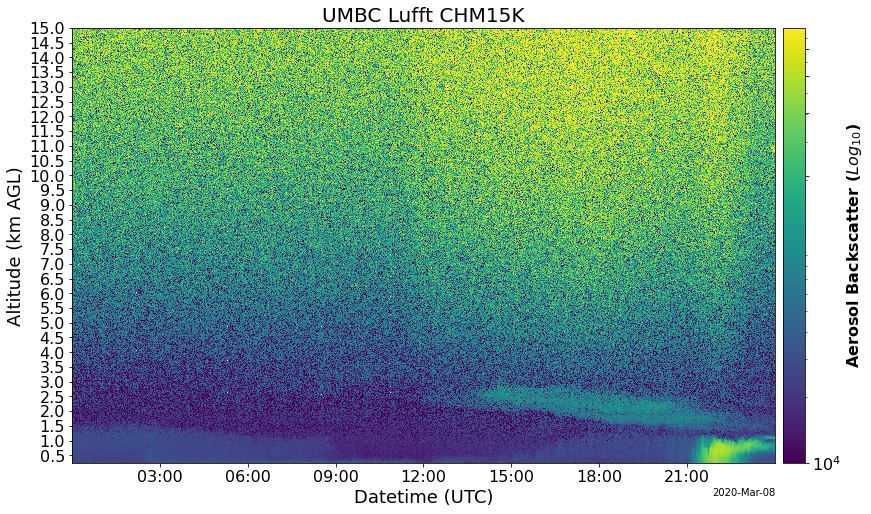

In [4]:
# Plotting the Ceilometer curtain with attributes
parms = {"data": Catonsville_ceilometer,
         "ylims": [0.25, 15],
         "yticks": np.arange(0.5, 15.1, 0.5),
         "clims": [10**4.0, 10**6.0],
         "title": r"UMBC Lufft CHM15K",
         "savefig": f"20200308_Catonsville-MD_CHM160112_000.png"}

X, Y, Z = plot(**parms)

## Rayleigh Backsatter Coefficient
a common practice is to use the following euqation
### $\beta_{Rayleigh} (\lambda, z, \theta = \pi) = 2.938 \times 10^{-32} \frac{P(z)}{T(z)} \cdot \frac{1}{\lambda^{4.0117}} (m^{-1}sr^{-1})$

### $T_{Rayleigh} = exp(-2 \int_{z_0}^{z} \alpha(z') \cdot dz)$

In [5]:
RCS = Catonsville_ceilometer["20200308_Catonsville-MD_CHM160112_000.nc"]["beta_raw"]
altitude = Catonsville_ceilometer["20200308_Catonsville-MD_CHM160112_000.nc"]["range"]/1000
dateTime = Catonsville_ceilometer["20200308_Catonsville-MD_CHM160112_000.nc"]["datetime"]

In [6]:
print(altitude[190], altitude[650])

2.862135 9.755236


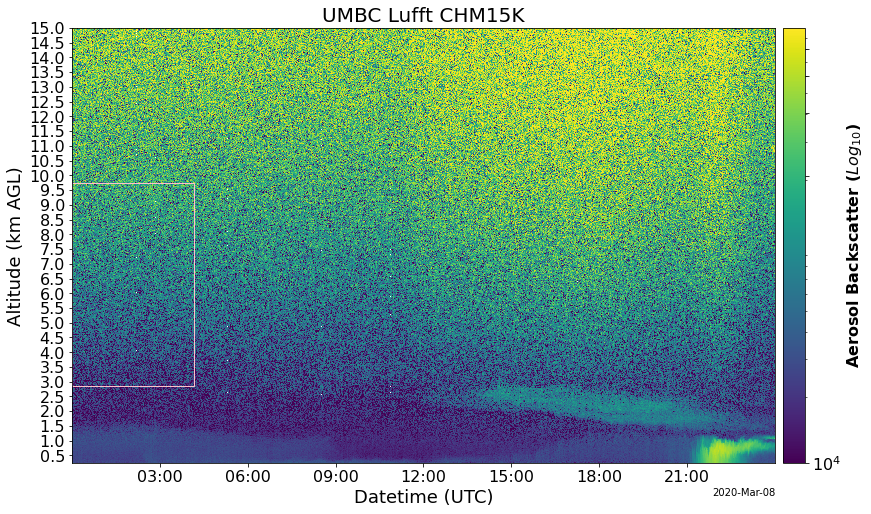

In [7]:
H = [2.862, 9.755, 0.01]
tr = [0, 1000]

# Plotting the Ceilometer curtain with attributes
parms = {"data": Catonsville_ceilometer,
         "ylims": [0.25, 15],
         "yticks": np.arange(0.5, 15.1, 0.5),
         "clims": [10**4, 10**6.0],
         "title": r"UMBC Lufft CHM15K",
         "target": ((dateTime[tr[0]], H[0]), dateTime[tr[1]]-dateTime[tr[0]], H[1]-H[0]),
         "savefig": f"20200308_Catonsville-MD_CHM160112_000.png"}

X, Y, Z = plot(**parms)

The region in the pink rectangle is then averaged into a single vertical profile (plotted below). This region looks fairly clean. There is minus noise from solar radiation, and is avove the nocturnal layer. With these in mind, this region should be closes to a pure rayleight scattering regime. 

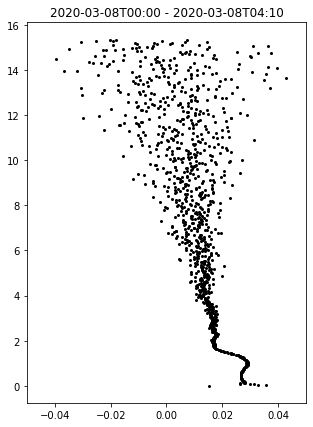

In [8]:
RCS_avg = np.nanmean(RCS[:, tr[0]:tr[1]], axis=1)

plt.figure(figsize=(5, 7))
plt.title(f"{dateTime[tr[0]].astype('datetime64[m]')} - {dateTime[tr[1]].astype('datetime64[m]')}")
plt.plot(RCS_avg / 1000**2, altitude, label="RCS", color="k", marker="o", linestyle="", markersize=2)
plt.xlim(-0.05, 0.05)
plt.show()

#### Rayleight Scattering Profile
Here the Rayleigh scatering profile is calculated using a United States Standard Atmosphere (SA76) profile of pressure and temperature. The SA76 profile is then used to calculate the molecular transmittance ($\beta_m \cdot T^2_m$) profile for 1064 nm. 

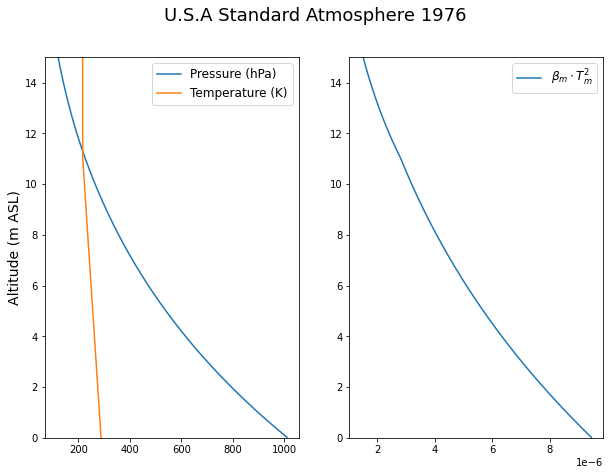

In [9]:
P, T = SA76(altitude)

wavelength = 1064e-9
betaMol = beta_mol(P, T, wavelength)
transMol = trans_mol(betaMol, altitude)
beta_dot_trans = betaMol * transMol

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 7))
plt.suptitle("U.S.A Standard Atmosphere 1976", fontsize=18)

ax1.plot(P/100, altitude, label="Pressure (hPa)")
ax1.plot(T, altitude, label="Temperature (K)")
ax1.set_ylabel("Altitude (m ASL)", fontsize=14)
ax1.set_ylim(0, 15)
ax1.legend(fontsize=12)

ax2.plot(beta_dot_trans, altitude, label=r"$\beta_m \cdot T^2_m$")
ax2.set_ylim(0, 15)
ax2.legend(fontsize=12)

plt.show()

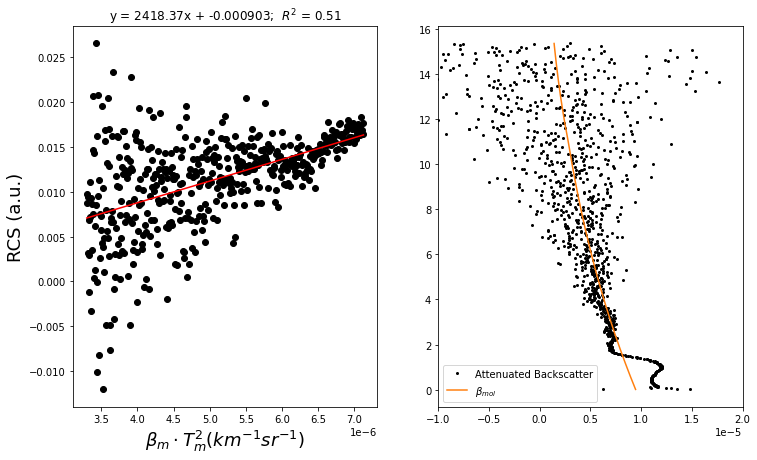

In [10]:
beta_dot_trans_new = binned_alts(beta_dot_trans, altitude, bins=np.arange(*H));
beta_dot_trans_new = beta_dot_trans_new.data
RCS_new = binned_alts(RCS_avg, altitude, bins=np.arange(*H));
RCS_new = RCS_new.data;
RCS_new /= (1000**2)

res = stats.linregress(beta_dot_trans_new, RCS_new)
attenuated_backscatter = RCS_avg / np.abs(res.slope)
x = beta_dot_trans_new

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
ax1.plot(beta_dot_trans_new, RCS_new, "ok")
ax1.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
ax1.set_ylabel("RCS (a.u.)", fontsize=18)
ax1.set_xlabel(r"$\beta_m \cdot T^2_m (km^{-1} sr^{-1})$", fontsize=18)
ax1.set_title(f"y = {round(res.slope, 2) / 10}x + {round(res.intercept, 6)};  $R^2$ = {round(res.rvalue, 2)}")

ax2.plot(attenuated_backscatter / (1000**2), altitude, label="Attenuated Backscatter", color="k", marker="o", linestyle="", markersize=2)
ax2.plot(betaMol, altitude, label=r"$\beta_{mol}$", color="tab:orange")
ax2.set_xlim(-1e-5, 2e-5)

ax2.legend()

plt.show()